# Modelo de predicción sobre encuesta con XGBoost

Siguiendo los pasos del cuaderno, vamos a crear un modelo de aprendizaje automático predictivo.

El objetivo de nuestro modelo va a ser predecir un campo en base a otra información del mismo registro.

## Leer el archivo de entramiento

In [0]:

from pyspark.sql import SparkSession

# Crear sesión de Spark
spark = SparkSession.builder.appName("ChallengeIA").getOrCreate()

# Cargar datos desde Databricks File System (DBFS) usando PySpark
file_path = "/FileStore/Challenges/reto_01/encuesta17.csv"
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)


## Aplicar las transformaciones necesarias para limpiar el CSV (quitar nulos, filtrar por edades reales...)
La calidad de los datos va a determinar la precisión de nuestro modelo

In [0]:

import pandas as pd

# Convertir el DataFrame de Spark a pandas para hacer las transformaciones
data = df_spark.toPandas()

# Limpiar datos usando pandas
data['age'] = data['age'].fillna(data['age'].median())
data['candidate_preference'] = data['candidate_preference'].fillna("Sin preferencia")
data['type'] = data['type'].fillna("Desconocido")
data = data[(data['age'] >= 18) & (data['age'] <= 100)]

# Convertir el DataFrame de pandas de nuevo a Spark para análisis en Databricks
df_spark_transformed = spark.createDataFrame(data)
df_spark_transformed.show()


+-------+---+---------+--------------------+----------+-----------+
|user_id|age| location|candidate_preference|time_spent|       type|
+-------+---+---------+--------------------+----------+-----------+
|      1| 42| Valencia|                 Ana|       137|Funcionario|
|      2| 87|   Madrid|                Juan|        85|   Retirado|
|      3| 48|   Madrid|     Sin preferencia|        71|   Empleado|
|      4| 36| Valencia|     Sin preferencia|       137|   Empleado|
|      5| 66|   Madrid|                 Ana|       174|   Retirado|
|      6| 82|Barcelona|                Juan|       133| Empresario|
|      7| 51|   Madrid|                Juan|        88|Funcionario|
|      8| 20|Barcelona|                 Ana|        27| Estudiante|
|      9| 52|  Sevilla|                 Ana|       111|   Empleado|
|     10| 45|Barcelona|                 Ana|       122|   Empleado|
|     11| 38| Valencia|     Sin preferencia|       151|   Empleado|
|     12| 86|  Sevilla|                 Ana|    

## Exploración de datos

### En estas celdas de código podemos hacer todo tipo de búsqueda/gráficas con la que se pueda sacar valor de los datos
Varios ejemplos serían:
- El candidato preferido de cada región.
- La edad media de los votantes de cada candidato
- Porcentaje de votos recibidos por cada candidato en cada región
- Número de votos de cada candidato (independientemente de la región)
- El tiempo medio de votación de cada candidato

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pandas = df_spark_transformed.select("*").toPandas()

### Candidato preferido de cada región

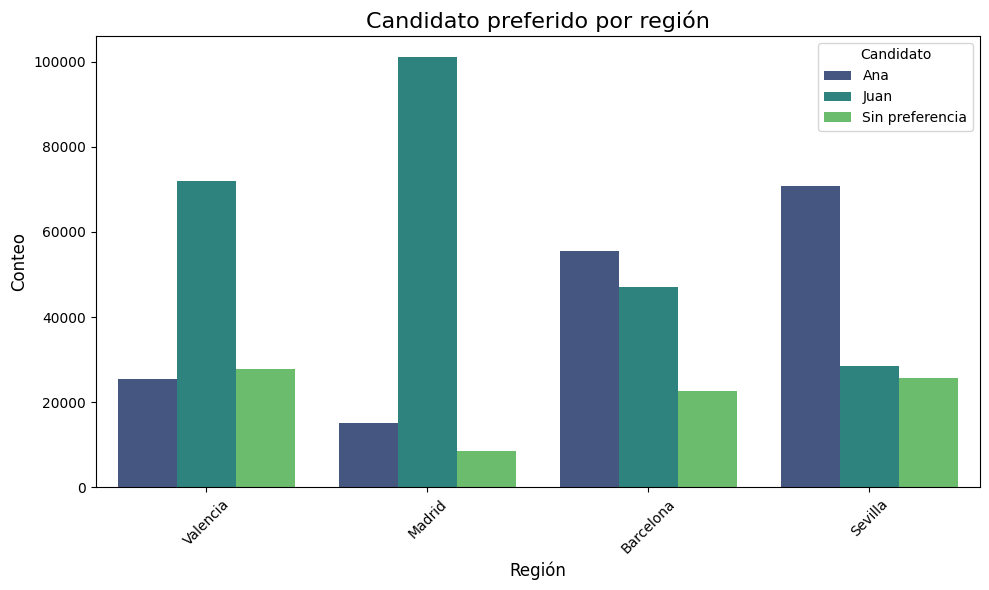

In [0]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_pandas, x='location', hue='candidate_preference', palette='viridis')
plt.title('Candidato preferido por región', fontsize=16)
plt.xlabel('Región', fontsize=12)
plt.ylabel('Conteo', fontsize=12)
plt.legend(title='Candidato', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Edad media de los votantes a cada candidato

  candidate_preference        age
0                  Ana  46.357920
1                 Juan  59.614979
2      Sin preferencia  52.246868


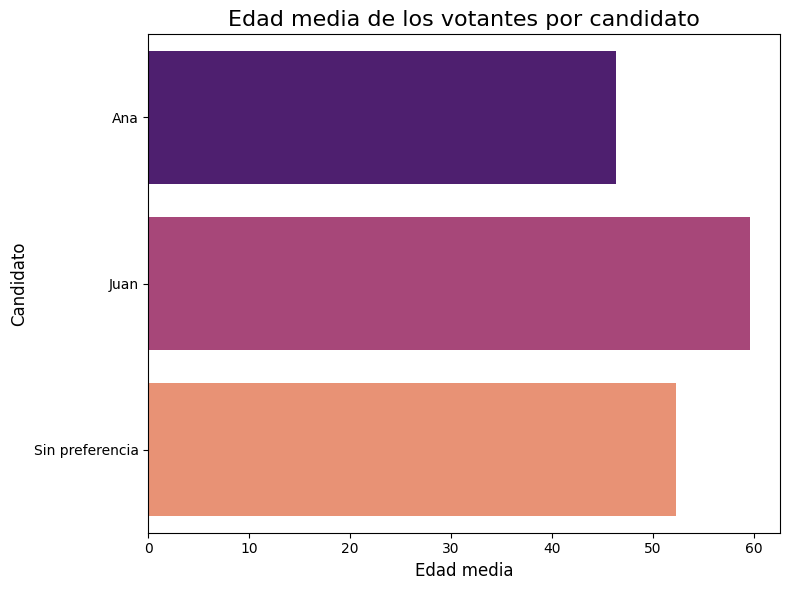

In [0]:
edad_media_por_candidato = df_pandas.groupby('candidate_preference')['age'].mean().reset_index()

print(edad_media_por_candidato)

plt.figure(figsize=(8, 6))
sns.barplot(data=edad_media_por_candidato, x='age', y='candidate_preference', palette='magma')
plt.title('Edad media de los votantes por candidato', fontsize=16)
plt.xlabel('Edad media', fontsize=12)
plt.ylabel('Candidato', fontsize=12)
plt.tight_layout()
plt.show()


### Tipos de registros por candidato

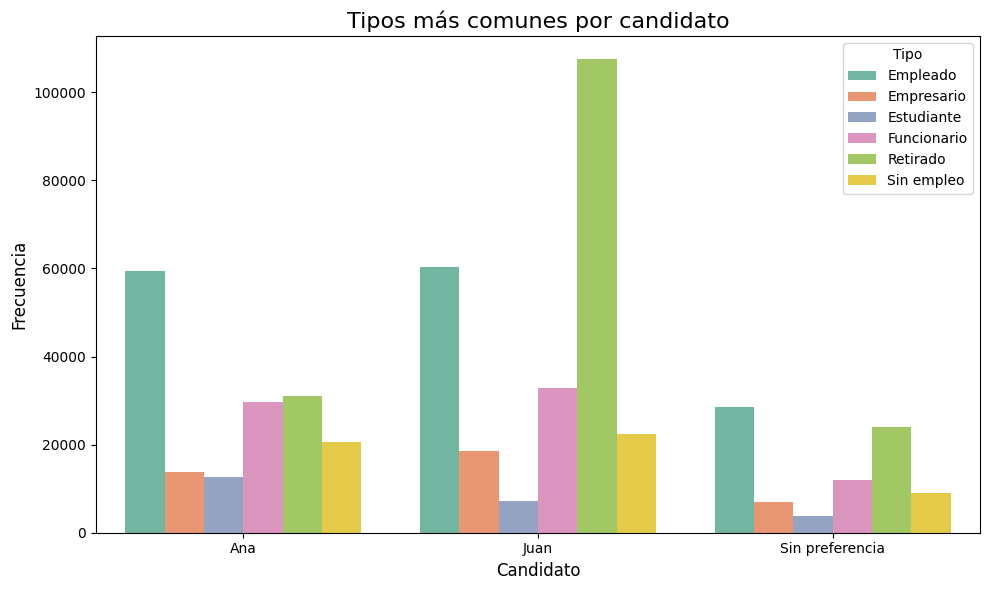

In [0]:
top_types_df = df_pandas.groupby(['candidate_preference', 'type']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.barplot(data=top_types_df, x='candidate_preference', y='count', hue='type', palette='Set2')
plt.title('Tipos más comunes por candidato', fontsize=16)
plt.xlabel('Candidato', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend(title='Tipo', loc='upper right')
plt.tight_layout()
plt.show()


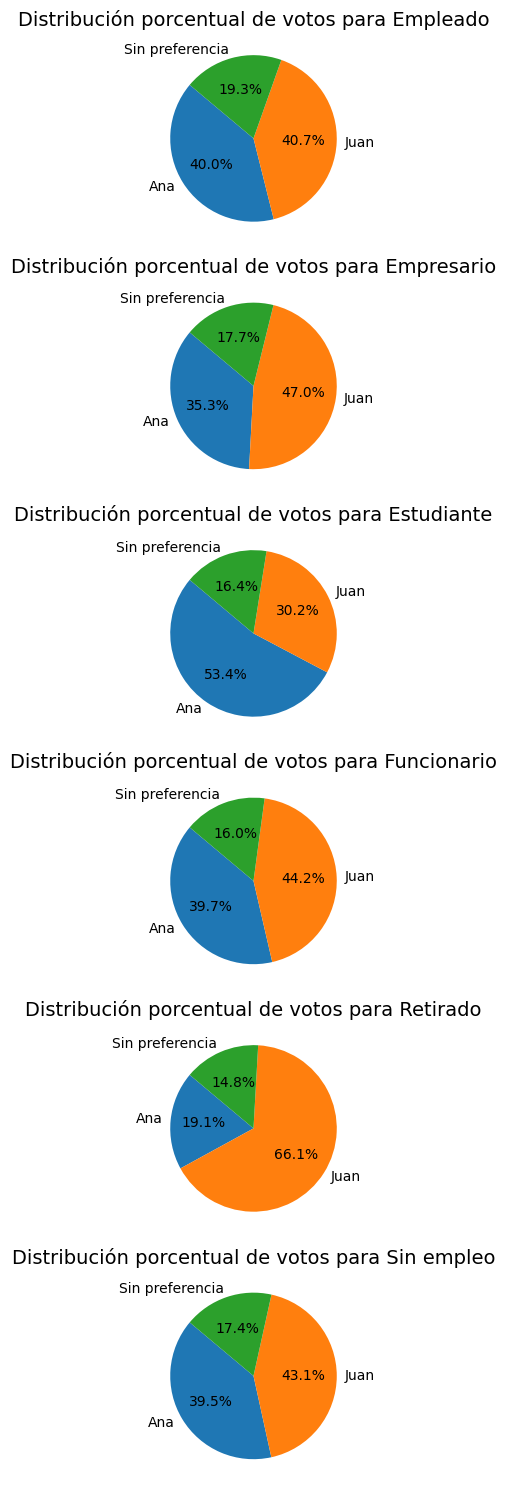

In [0]:
type_candidate_counts = (
    df_pandas.groupby(['type', 'candidate_preference'])
    .size()
    .reset_index(name='count')
)

# Calcular el total de votos por cada 'type'
total_per_type = type_candidate_counts.groupby('type')['count'].transform('sum')

# Calcular el porcentaje de votos de cada candidato dentro de cada 'type'
type_candidate_counts['percentage'] = (type_candidate_counts['count'] / total_per_type) * 100

# Crear una paleta de colores fija asociada a los candidatos
unique_candidates = type_candidate_counts['candidate_preference'].unique()
candidate_colors = {candidate: color for candidate, color in zip(unique_candidates, plt.cm.tab10.colors)}

# Generar un gráfico de pie por cada 'type'
types = type_candidate_counts['type'].unique()

plt.figure(figsize=(15, 15))
for i, t in enumerate(types, 1):
    plt.subplot(len(types), 1, i)  # Crear subplots para cada tipo
    data = type_candidate_counts[type_candidate_counts['type'] == t]
    colors = [candidate_colors[candidate] for candidate in data['candidate_preference']]
    plt.pie(
        data['percentage'],
        labels=data['candidate_preference'],
        autopct='%1.1f%%',
        colors=colors,
        startangle=140,
    )
    plt.title(f'Distribución porcentual de votos para {t}', fontsize=14)

plt.tight_layout()
plt.show()


### Tiempo medio de los votantes de cada candidato

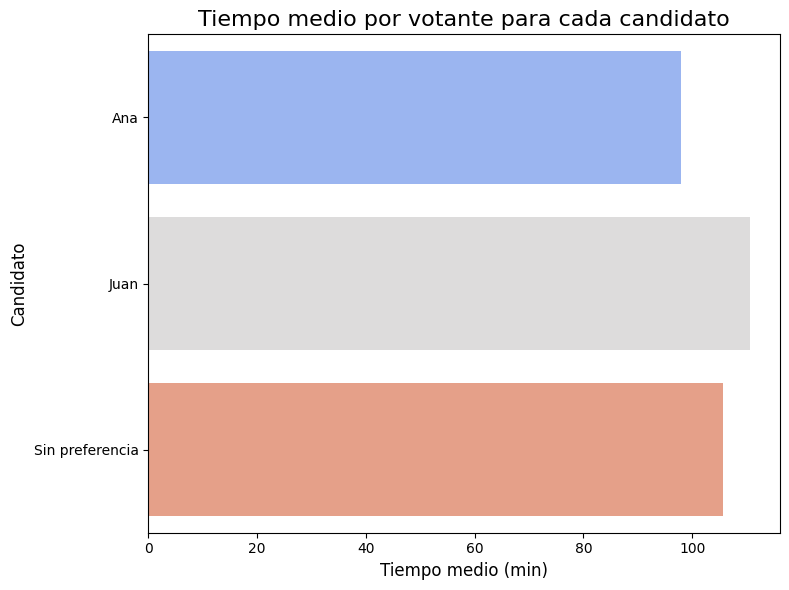

In [0]:
tiempo_medio_por_candidato = df_pandas.groupby('candidate_preference')['time_spent'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=tiempo_medio_por_candidato, x='time_spent', y='candidate_preference', palette='coolwarm')
plt.title('Tiempo medio por votante para cada candidato', fontsize=16)
plt.xlabel('Tiempo medio (min)', fontsize=12)
plt.ylabel('Candidato', fontsize=12)
plt.tight_layout()
plt.show()


### Tiempo medio por tipo

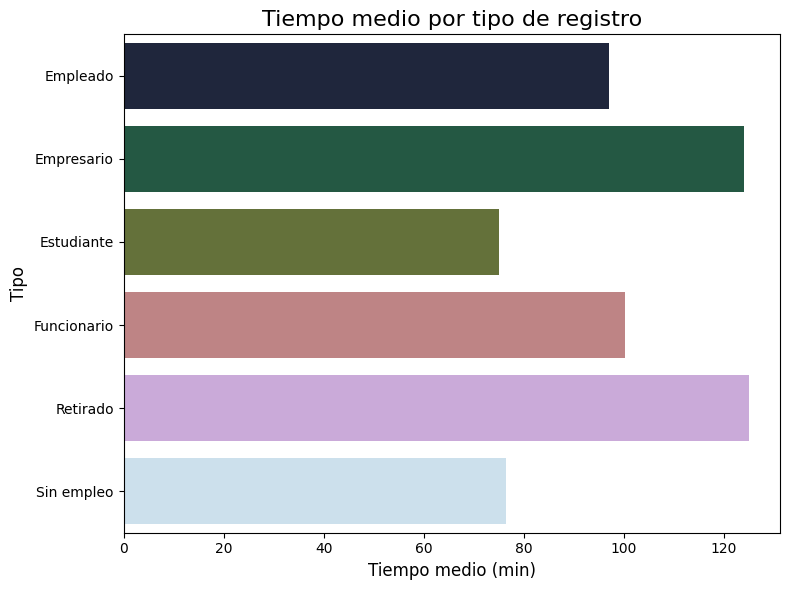

In [0]:
tiempo_medio_por_type = df_pandas.groupby('type')['time_spent'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=tiempo_medio_por_type, x='time_spent', y='type', palette='cubehelix')
plt.title('Tiempo medio por tipo de registro', fontsize=16)
plt.xlabel('Tiempo medio (min)', fontsize=12)
plt.ylabel('Tipo', fontsize=12)
plt.tight_layout()
plt.show()


## Preprocesamiento de datos

#### Aqui transformamos los datos para asegurarnos de tener un formato adecuado con el que entrenar el modelo
#### **1. Transformación de Columnas Categóricas a Valores Numéricos**
- Se utilizan **`StringIndexer`** para convertir las columnas categóricas en valores numéricos:
  - **`location`**
  - **`type`**
  - **`candidate_preference`** (que se transforma en la columna objetivo `label`)

#### **2. Codificación de las Categorías**
- Las columnas categóricas indexadas se codifican en formato **One-Hot Encoding** mediante **`OneHotEncoder`**, lo que representa cada categoría como un vector binario

#### **3. Creación de un Vector de Características**
- Se combinan las columnas relevantes en un único vector llamado `features` utilizando **`VectorAssembler`**:
  - **`age`**
  - **`time_spent`**
  - **`location_encoded`**
  - **`type_encoded`**

#### **4. Uso de un Pipeline para Automatizar el Proceso**
- Todas las transformaciones (indexación, codificación y ensamblado) se agrupan en un único flujo mediante un **`Pipeline`**
- El **Pipeline** se entrena con los datos (`pipeline.fit`) y las transformaciones resultantes se aplican automáticamente a los datos originales (`pipeline_model.transform`)



In [0]:

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Indexar columnas categóricas
location_indexer = StringIndexer(inputCol="location", outputCol="location_index")
type_indexer = StringIndexer(inputCol="type", outputCol="type_index")
preference_indexer = StringIndexer(inputCol="candidate_preference", outputCol="label")

# Codificar columnas
location_encoder = OneHotEncoder(inputCol="location_index", outputCol="location_encoded")
type_encoder = OneHotEncoder(inputCol="type_index", outputCol="type_encoded")

# Ensamblar características
assembler = VectorAssembler(
    inputCols=["age", "time_spent", "location_encoded", "type_encoded"],
    outputCol="features"
)

# Construir pipeline
pipeline = Pipeline(stages=[location_indexer, type_indexer, preference_indexer, location_encoder, type_encoder, assembler])

# Ajustar el pipeline y preparar los datos
pipeline_model = pipeline.fit(df_spark_transformed)
df_prepared = pipeline_model.transform(df_spark_transformed)


## Convertir los datos preprocesados para entrenar el modelo

### XGBoost trabaja con estructuras de datos de NumPy por ello tenemos que adaptar los datos

#### **1. Conversión del DataFrame a pandas**
- Se transforma el **DataFrame** de Spark en un DataFrame de **pandas** para facilitar la manipulación y compatibilidad con las herramientas de NumPy y XGBoost

#### **2. Conversión de `features` a un Array Denso**
- La columna `features` en el DataFrame contiene vectores dispersos (SparseVectors). Estos se convierten en arrays densos, una estructura más eficiente y adecuada para operaciones matemáticas

#### **3. Separación de Características y Etiquetas**
- Separamos:
  - **Características (`features`)**: Representan las variables predictoras o entradas del modelo (X)
  - **Etiqueta (`label`)**: Es la variable objetivo o salida que se desea predecir (y)

#### **4. Apilamiento de las Características**
- Las características (`features`) se organizan en una matriz bidimensional utilizando `np.vstack`. Esto asegura que cada fila representa un registro y cada columna, una variable

#### **5. Conversión de Etiquetas a un Array**
- La columna de etiquetas (`label`) se transforma en un array de NumPy para facilitar el manejo y procesamiento de XGBoost


In [0]:
import numpy as np

# Convertir DataFrame de Spark a pandas
df_pandas = df_prepared.select("features", "label").toPandas()

# Convertir la columna 'features' (SparseVector) a un array denso
df_pandas['features'] = df_pandas['features'].apply(lambda x: x.toArray())

# Separar las características y la label
X = np.vstack(df_pandas["features"].values)
y = df_pandas["label"].values


## Instalar XGBoost
Yo he elegido XGBooster por recursos y tiempo

In [0]:
pip install xgboost

Es posible que sea necesario reiniciar el cluster después de instalar la librería

Ejecuta el siguiente comando en una celda


```

dbutils.library.restartPython()


```

## Configuración, Entrenamiento y Evaluación del Modelo


En esta celda se configura, se entrena y se mide la precisión del modelo

#### División de Datos
- El conjunto de datos se divide en:
  - **80% para entrenamiento**
  - **20% para prueba**

#### Conversión a Formato `DMatrix`
- Los datos se convierten al formato especializado `DMatrix` de XGBoost, diseñado para manejar grandes conjuntos de datos de manera eficiente

#### Configuración de Parámetros del Modelo
- Se define un conjunto de parámetros clave para entrenar el modelo:
  - **`objective`: `multi:softprob`**
    - Indica que el objetivo es realizar una clasificación multiclase con salida en forma de probabilidades
  - **`num_class`**
    - Número de clases o categorías en la variable objetivo
  - **`max_depth`**
    - Profundidad máxima de los árboles (complejidad del modelo)
  - **`eta`**
    - Tasa de aprendizaje que ajusta gradualmente el modelo para evitar sobreajuste
  - **`eval_metric`: `mlogloss`**
    - Métrica utilizada para evaluar el rendimiento durante el entrenamiento

#### Entrenamiento del Modelo
- Se entrena el modelo utilizando los datos de entrenamiento y los parámetros configurados

#### Predicción y Evaluación
- Se generan predicciones para los datos de prueba
- La precisión del modelo se mide comparando las etiquetas reales con las etiquetas predichas, calculando así la **precisión (accuracy)**



In [0]:

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir los datos a DMatrix para XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Configurar parámetros de XGBoost
params = {
    "objective": "multi:softprob",  # Obtener probabilidades
    "num_class": len(np.unique(y)),
    "max_depth": 6,
    "eta": 0.3,
    "eval_metric": "mlogloss"
}

# Entrenar el modelo
num_round = 100
model = xgb.train(params, dtrain, num_round)

# Evaluar el modelo
predictions = model.predict(dtest)
predicted_classes = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Precisión del modelo: {accuracy:.2f}")


Precisión del modelo: 0.65


## Predicción de Nuevos Datos con el Modelo Entrenado

En esta celda introducimos los nuevos datos y utilizamos el modelo para predecir las probabilidades de preferencia por cada registro

### **1. Carga de nuevos datos**
- Cargamos el archivo de la misma manera que hemos hecho al princinpio

### **2. Transformación de datos con el pipeline**
- Se aplica el pipeline entrenado (`pipeline_model`) para realizar las mismas transformaciones aplicadas a los datos de entrenamiento:
  - Indexación de categorías
  - Codificación de características
  - Ensamblado en un vector de características (`features`)

### **3. Conversión a pandas y procesamiento de características**
- Se selecciona únicamente la columna `features` del DataFrame transformado
- El vector disperso (`SparseVector`) de la columna `features` se convierte en arrays densos usando `apply(lambda x: x.toArray())`
- Las características se organizan en una matriz bidimensional `X_new` con `np.vstack()` para ser procesadas por el modelo

### **4. Preparación para predicción**
- Se crea un objeto `DMatrix`  (`X_new`) para alimentar el modelo XGBoost

### **5. Predicción de probabilidades**
- El modelo entrenado (`model`) genera predicciones como probabilidades para cada clase (`new_predictions`)

### **6. Asignación de nombres reales a las clases**
- Se obtienen los nombres originales de las clases desde el `StringIndexer` del pipeline (`preference_indexer`), almacenados en `pipeline_model.stages[2].labels`

### **7. Conversión a un DataFrame legible**
- Se crea un DataFrame `probabilities_df` que contiene:
  - Las probabilidades de cada clase para cada registro
  - Opcionalmente, se agrega la columna `user_id` del conjunto de datos original para facilitar la referencia



In [0]:
# Cargar nuevos datos
file_path = "dbfs:/FileStore/Challenges/reto_01/prueba_data2.csv"
new_data_spark = spark.read.csv(file_path, header=True, inferSchema=True)

# Aplicar el pipeline para transformar los nuevos datos
new_data_prepared = pipeline_model.transform(new_data_spark)

# Seleccionar las columnas necesarias y convertir a pandas
new_data_pandas = new_data_prepared.select("features").toPandas()
new_data_pandas["features"] = new_data_pandas["features"].apply(lambda x: x.toArray())

# Preparar características para predicción
X_new = np.vstack(new_data_pandas["features"].values)
dnew = xgb.DMatrix(X_new)

# Realizar predicciones
new_predictions = model.predict(dnew)

# Obtener los nombres de las clases desde el StringIndexer entrenado
class_labels = pipeline_model.stages[2].labels  # El índice 2 corresponde a 'preference_indexer'

# Convertir probabilidades en un DataFrame con los nombres reales de las clases
probabilities_df = pd.DataFrame(new_predictions, columns=class_labels)

# Agregar identificadores de usuario para referencia (opcional)
probabilities_df['user_id'] = new_data_spark.select('user_id').toPandas()

# Mostrar y guardar las probabilidades
display(probabilities_df)


Juan,Ana,Sin preferencia,user_id
0.75636524,0.08591894,0.1577158,1
0.993497,0.0058038654,6.990874E-4,2
0.41708106,0.36039573,0.22252324,3
0.4223485,0.30025017,0.2774013,4
0.5909346,0.2300237,0.17904173,5
0.9365685,0.033097982,0.030333519,6
0.3576266,0.42964548,0.21272798,7
0.12351152,0.87309486,0.0033936407,8
0.19229455,0.6931388,0.114566684,9
0.4097894,0.38866976,0.20154081,10


In [0]:
# Formatear las columnas de probabilidades como porcentaje
probabilities_df_percentage = probabilities_df.copy()

# Convertir cada columna de probabilidad a formato porcentaje
for column in probabilities_df.columns[:-1]:  # Excluyendo 'user_id' si está presente
    probabilities_df_percentage[column] = probabilities_df[column].apply(lambda x: f"{x:.2%}")

# Mostrar el DataFrame formateado
display(probabilities_df_percentage)

Juan,Ana,Sin preferencia,user_id
97.57%,1.73%,0.70%,1
0.13%,0.06%,99.81%,2
53.72%,44.69%,1.59%,3
0.10%,0.11%,99.79%,4
91.93%,3.59%,4.49%,5
74.50%,9.53%,15.97%,6
47.33%,34.93%,17.75%,7
0.20%,0.70%,99.09%,8
70.74%,22.24%,7.03%,9
40.49%,37.78%,21.73%,10
